In [1]:
# %pip install pickleshare

In [2]:
import os
os.chdir('/Code/ditto_v2')

In [3]:
%pwd

'c:\\Code\\ditto_v2'

In [4]:
from src.functionality_maps import f_maps, paths
import geopandas as gpd

## PREPARATION

### INPUTS

In [5]:
l_country_data = [
    # 'D1','D2','D3',
    'D4',
    # 'ZIP',
    'census'
    ]
l_coverage = '20'

# l_stores = ['sportscheck', 'decathlon','intersport','sport2000','sportxx','karstadt','engelhorn','sportarena','sportcheck','sportsohle]
l_stores = ['sportscheck']

# l_states = ['Bayern','Baden-Württemberg','Hessen','Nordrhein-Westfalen','Rheinland-Pfalz', \
#             'Saarland','Sachsen','Sachsen-Anhalt','Thüringen','Berlin','Brandenburg','Mecklenburg-Vorpommern', \
#                 'Hamburg','Niedersachsen','Schleswig-Holstein','Bremen']
l_states = ['Niedersachsen']

is_logging = True
round_dec = 2

### LOAD DATA

In [6]:
########## LOAD 'GERMANY' `d_ger` ##############
import pandas as pd

pd.set_option('display.max_columns', None)
d_ger = f_maps.load_germany(l_levels=l_country_data,
                            is_logging=True)

gpd_zensus = d_ger['census']
# print(d_ger['D4'].shape)
# d_ger['D4'].head()
gpd_zensus.head(1)

Level [D4-District] loaded!
Census is loaded!


,OBJID,BEGINN,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,BEM,NBD,SN_L,SN_R,SN_K,SN_V1,SN_V2,SN_G,FK_S3,NUTS,ARS_0,AGS_0,WSK,EWZ,KFL,DLM_ID,EPK,EPK_norm,geometry
0,DEBKGVG200000008,2022-12-20,6,4,1,010010000000,01001000,010010000000,Flensburg,Stadt,60,kreisfrei,ja,01,0,01,00,00,000,R,DEF01,010010000000,01001000,2008-01-01,92550,56,DEBKGDL20000E5MA,1652.678571,0.0,"POLYGON ((9.41266 54.82264, 9.41318 54.82124, ..."


### PREPARE DATA

In [7]:
#### GPD_ZENSUS ########
print('Removing non-serializable columns...')
l_cols_non_serializable = ['WSK','BEGINN']
for col in l_cols_non_serializable:
    if col in gpd_zensus.columns:
        gpd_zensus = gpd_zensus.drop(col,axis=1)
        if(is_logging):
            print(f' Removing [{col}]')
gpd_zensus.head(1)

#### PARSING VARIABLES ###
radius_km = int(l_coverage)

Removing non-serializable columns...
 Removing [WSK]
 Removing [BEGINN]


### FILTERING BASED ON DATA 
[`pdf_stores`, `gpd_zensus_filt`, 
`gdf_geom_4326`, `gdf_geom_6993`]

In [8]:
from src.functionality_maps import f_maps, paths, Defs
import pandas as pd
import geopandas as gpd

print('Filtering stores...')
pdf_stores = pd.read_json(paths.stores, orient='records', lines=True)
pdf_stores = pdf_stores[pdf_stores['store'].isin(l_stores)]
print(f'  After filtering stores [{l_stores}]... # stores:{pdf_stores.shape[0]}')
pdf_stores = pdf_stores[pdf_stores['GADM_1'].isin(l_states)]
print(f'  After filtering states [{l_states}]... # stores:{pdf_stores.shape[0]}\n')
print(f'  Stores {list(pdf_stores['name'])}')

#### EXTRACTING LOCATIONS FROM STORES ####
l_center_points = list(zip(pdf_stores['lat'], pdf_stores['lon']))

Filtering stores...
  After filtering stores [['sportscheck']]... # stores:30
  After filtering states [['Niedersachsen']]... # stores:4

  Stores ['braunschweig', 'goettingen', 'hannover-mitte', 'hannover-osterstrasse']


In [17]:
#### FILTERING GEOMETRY #####
print('Filtering geometry...')
gpd_ger_d4 = d_ger["D4"]
l_bundeslaender = [Defs.dict_bundeslaender_id[x] for x in l_states]
print(f'  gpd_ger_d4:{gpd_ger_d4.shape[0]}')
gpd_ger_filt = gpd_ger_d4[gpd_ger_d4['NAME_1'].isin(l_states)]
print(f'  After filtering States, gpd_ger_filt:{gpd_ger_filt.shape[0]}')


#### FILTERING CENSUS #####
print('Filtering census...')
l_bundeslaender = [Defs.dict_bundeslaender_id[x] for x in l_states]
print(f'  gdf_zensus_filt:{gpd_zensus.shape[0]}')
gpd_zensus_filt = gpd_zensus[gpd_zensus['SN_L'].isin(l_bundeslaender)]
print(f'  After filtering States, gdf_zensus_filt:{gpd_zensus_filt.shape[0]}')

Filtering geometry...
  gpd_ger_d4:434
  After filtering States, gpd_ger_filt:45
Filtering census...
  gdf_zensus_filt:10990
  After filtering States, gdf_zensus_filt:964


In [31]:
#### COMPUTING AREAS ####
print('Computing areas...')
gdf_geom_6993 = gpd_zensus_filt.to_crs(epsg=6933)
gdf_geom_6993['KFL_GPD'] = round(gdf_geom_6993.geometry.area / 10**6, 2)
gdf_geom_4326 = gpd_zensus_filt.to_crs(epsg=4326)
gdf_geom_6993['centroid']=gdf_geom_6993.to_crs('+proj=cea').centroid.to_crs(gdf_geom_6993.crs)
gdf_geom_6993['centroid']= gdf_geom_6993['centroid'].to_crs(epsg=4326)
gdf_geom_6993['lat']=gdf_geom_6993['centroid'].y
gdf_geom_6993['lon']=gdf_geom_6993['centroid'].x

gdf_geom_6993.head(1)

Computing areas...


,OBJID,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,BEM,NBD,SN_L,SN_R,SN_K,SN_V1,SN_V2,SN_G,FK_S3,NUTS,ARS_0,AGS_0,EWZ,KFL,DLM_ID,EPK,EPK_norm,geometry,KFL_GPD,centroid,lat,lon
1109,DEBKGVG2000000V1,6,4,1,031010000000,03101000,031010000000,Braunschweig,Stadt,60,kreisfrei,ja,03,1,01,00,00,000,K,DE911,031010000000,03101000,251804,192,DEBKGDL20000E3JQ,1311.479167,0.0,"POLYGON ((1015262.99 5804063.982, 1015501.802 ...",192.26,POINT (10.52419 52.27525),52.275247,10.524188


## PROCESSING

## VISUALIZATION

### Feature Group Geometries (`fg_geom`)

In [ ]:
import folium

fg_geom_d4 = folium.FeatureGroup(name=f'Geometry [{l_states}]')
gjson = f_maps.get_folium_geojson(gpd_ger_filt, 
                                fields=['NAME_3'],
                                aliases = ['Name']
                                )
gjson.add_to(fg_geom_d4)
print('Geometries ready!')
# d_ger['D4'].head(1)

Geometries ready!


### Feature Group Center points (`fg_point`)

In [14]:
import folium
from src.functionality_maps import f_maps
from shapely import geometry



fg_points = f_maps.get_fg_markers(df=pdf_stores, 
                           name=f'Stores [{pdf_stores.shape[0]}]',
                           l_tooltip=['name', 'address'],
                           l_popup=['url'])

### Feature Group Circles `fg_circles`

In [15]:
gdf_store_circles = f_maps.get_gdf_circle(pdf_stores, radius_km, 'fgc2')
fg_circles = folium.FeatureGroup(name=f'Circles around stores [{gdf_store_circles.shape[0]}]')
gjson = f_maps.get_folium_geojson(gdf_store_circles, 
                                fields=['store','name', 'address'],
                                # aliases = ['Shop']
                                )
gjson.add_to(fg_circles)

### MAP with Feature Groups


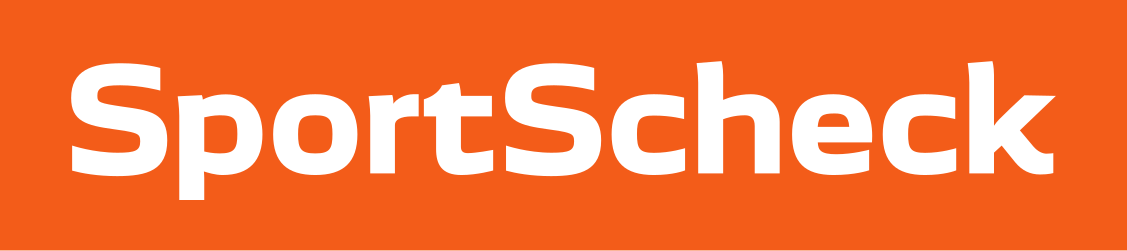
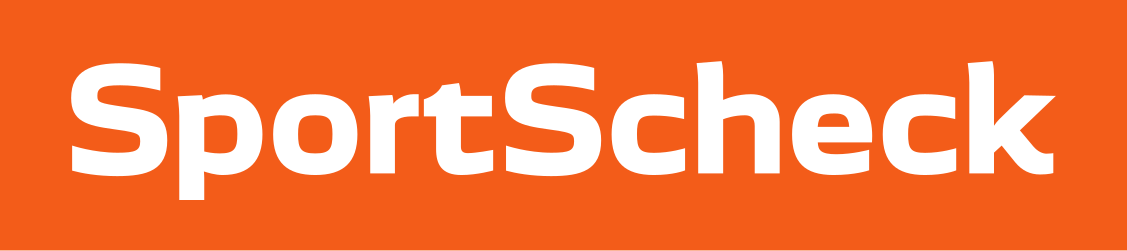
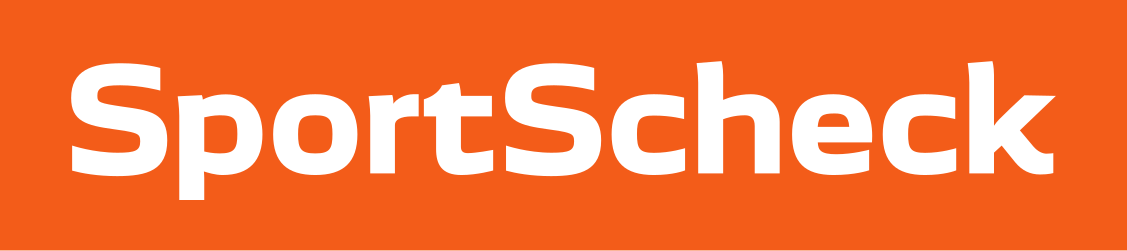
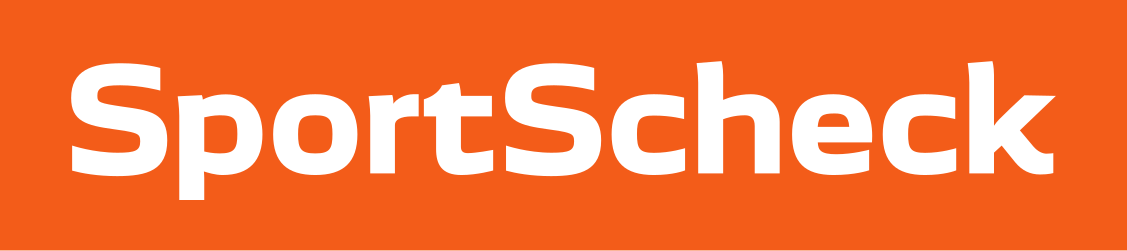

In [16]:
import folium

l_fg = [
    fg_geom_d4, 
    fg_points, 
    fg_circles,
    # fg_int, 
    # fg_overlay, fg_overlay_all, 
    #   fg_inside,fg_partly,
    #  fg_outside
    ]

m=folium.Map()
for fg in l_fg:
    fg.add_to(m)
folium.LayerControl(position='topright',collapsed=False).add_to(m)

m.fit_bounds(m.get_bounds())
m

### Rest of `monster code`

In [ ]:

l_fg = []
num_inside_towns, num_partly_towns = 0, 0
sum_ewz,sum_kfl, sum_area_geom_int = 0, 0, 0
sum_int_kfl, sum_int_ewz, sum_int_geom = 0, 0, 0


# l_fg_point, l_fg_circle, l_fg_merged = []
# l_fg_inside, l_fg_partly = []


fg_int = folium.FeatureGroup(name=f'Intersections')
fg_inside = folium.FeatureGroup(name=f'Markers - Inside towns')
fg_partly = folium.FeatureGroup(name=f'Markers - Partly towns')
fg_outside = folium.FeatureGroup(name=f'Markers - Outside towns')
fg_overlay = folium.FeatureGroup(name=f'Overlay - Summary inside')

l_gdf_circles = []
l_gdf_merged_circles = []



for i,center_point in enumerate(l_center_points):
    lon = center_point[1]
    lat = center_point[0]

    ############# INTERSECTION ####################
    gdf_de_int = gpd.sjoin(gdf_geom_4326, gdf_overlay, 
                        how="inner", predicate="intersects")

    gdf_de_int['KFL_GPD'] = round(gdf_geom_6993.geometry.area / 10**6, 2)
    int_kfl = gdf_de_int.KFL.sum()
    int_ewz =gdf_de_int.EWZ.sum()
    int_geom = round(gdf_de_int.KFL_GPD.sum(), 2)
    sum_int_kfl += int_kfl
    sum_int_ewz += int_ewz
    sum_int_geom += int_geom

    print(f'int_kfl={int_kfl}Km2, int_geom={int_geom}Km2, int_ewz={int_ewz}')

    gjson = f_maps.get_folium_geojson(gdf_de_int, 
                                      fields=['GEN', 'EWZ', 'KFL', 'KFL_GPD'],
                                        aliases = ['Name', 'Population', 'Area_KFL', 'Area_Geom'])
    gjson.add_to(fg_int)

    ############# OVERLAY / individual ####################

    col_perc = 'PERC_int'

    # Set the column used for NORMALIZATION (denominator)
    gdf_geom_6993['area_geom'] = round(gdf_geom_6993['geometry'].area / 10**6, 2)
    # Overlay geometry with polygon  
    gdf_overlay = gpd.overlay(gdf_geom_6993, gdf_circle_6933, how='intersection')

    # Set the column used for NORMALIZATION (numerator)
    gdf_overlay['area'] = round(gdf_overlay['geometry'].area / 10**6, 2)
    gdf_overlay[col_perc] = gdf_overlay['area'] / gdf_overlay['area_geom']
    
    
    d_columns = {
        'area_geom':{'alias' : 'area',        'is_norm': True,  'is_int':False},
        'KFL':     {'alias' : 'area_data',    'is_norm': True,  'is_int':False},
        'EWZ':     {'alias' : 'Population',   'is_norm': True,  'is_int':True}
    }
    
    gdf_overlay = f_maps.overlay_shapes(gdf_circle=gdf_overlay, 
                                        col_perc=col_perc, 
                                        d_columns=d_columns)


    # ################### Distance to point of interest ##########
    gdf = pd.DataFrame(gdf_overlay[['ARS','lat','lon','PERC_int','GEN']])
    gdf = gpd.GeoDataFrame(gdf, crs='epsg:4326', 
                           geometry=[geometry.Point(xy) for xy in zip(gdf['lon'], gdf['lat'])])
    gdf = f_maps.compute_dist_to_lat_lon(gdf, lon=geom_center_point.x, lat=geom_center_point.y, round_dec=2, units='km')

    #######################  Gemeinde Markers  ##########################
    
    gdf_inside = gdf[gdf[col_perc] == 1.0]
    num_inside_towns += gdf_inside.shape[0]
    print(f'Inside ={ gdf_inside.shape[0]}')
    fg_inside_circle = f_maps.get_markers_polygon(gdf_inside, 
                                               name=f'Markers inside {gdf_inside.shape[0]}', 
                                               l_tooltip=['GEN','dist'], 
                                               color='darkgreen')
    
    fg_inside_circle.add_to(fg_inside)

    gdf_partly = gdf[gdf[col_perc] != 1.0]
    num_partly_towns += gdf_partly.shape[0]
    fg_partly_circle = f_maps.get_markers_polygon(gdf_partly, 
                                               name=f'Markers partly {gdf_partly.shape[0]}', 
                                               l_tooltip=['GEN','dist'], 
                                               color='orange')
    fg_partly_circle.add_to(fg_partly)


    # gdf_outside = gdf[gdf[col_perc] != 1.0]
    
    ############# OVERLAY / merged ####################

    l_cols_percentaged = ['area_geom', 'EWZ', 'KFL']
    gdf_merge = f_maps.merge_shapes(gdf_overlay, l_col_percs=l_cols_percentaged,
                                    d_percs={'data':'KFL', 'geom':'area_geom'}, 
                                    num_dec=round_dec, is_logging=True)

    gdf_merge['num_in'] = gdf_inside.shape[0]
    gdf_merge['num_part'] = gdf_partly.shape[0]

    l_gdf_merged_circles.append(gdf_merge)
    
    gjson = f_maps.get_folium_geojson(
        gdf_merge, 
        fields=[
            'perc_data', 
            'KFL_int', 'KFL',
            'perc_geom',
            'area_geom_int', 'area_geom',
            'EWZ_int', 'EWZ',
            'num_in', 'num_part', 
            ],
        aliases = [
            'Percentage data', 
            'Area_data intersection [Km2]', 'Area_data shape [Km2]',
            'Percentage geometry',
            'Area_geom intersection [Km2]', 'Area_geom shape [Km2]',
            'Population intersection', 'Population shape',
            '# Localities inside', 
            '# Localities partially inside',
            ])
    gjson.add_to(fg_overlay)
    sum_ewz += gdf_merge['EWZ_int'].sum()
    sum_kfl += gdf_merge['KFL_int'].sum()
    sum_area_geom_int += gdf_merge['area_geom_int'].sum()
    print(f'area_geom_int= {sum_area_geom_int}\n')

Processing [1/4] POINT (10.522596726896484 52.26267905)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


int_kfl=2030Km2, int_geom=2053.15Km2, int_ewz=793509
Inside =23
area_geom = 2053.15
area_geom_int = 1259.54
EWZ = 793509
EWZ_int = 537651
KFL = 2030
KFL_int = 1242.69
perc_data = 0.61
perc_geom = 0.61
area_geom_int= 1259.54

Processing [2/4] POINT (9.935782433692971 51.5324763)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


int_kfl=1593Km2, int_geom=1608.73Km2, int_ewz=325708
Inside =18
area_geom = 1608.73
area_geom_int = 1118.04
EWZ = 325708
EWZ_int = 248570
KFL = 1593
KFL_int = 1106.81
perc_data = 0.69
perc_geom = 0.69
area_geom_int= 2377.58

Processing [3/4] POINT (9.738106126061068 52.375336250000004)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


int_kfl=2367Km2, int_geom=2378.68Km2, int_ewz=1214819
Inside =9
area_geom = 2378.68
area_geom_int = 1259.6
EWZ = 1214819
EWZ_int = 986131
KFL = 2367
KFL_int = 1251.95
perc_data = 0.53
perc_geom = 0.53
area_geom_int= 3637.18

Processing [4/4] POINT (9.73780461509109 52.372160550000004)
int_kfl=2367Km2, int_geom=2378.68Km2, int_ewz=1214819


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


Inside =9
area_geom = 2378.68
area_geom_int = 1259.58
EWZ = 1214819
EWZ_int = 987163
KFL = 2367
KFL_int = 1251.94
perc_data = 0.53
perc_geom = 0.53
area_geom_int= 4896.76



In [ ]:

fg_inside.layer_name = fg_inside.layer_name + f'[{num_inside_towns}/{gpd_zensus_filt.shape[0]}]'
fg_partly.layer_name = fg_partly.layer_name + f'[{num_partly_towns}/{gpd_zensus_filt.shape[0]}]'
fg_int.layer_name = fg_int.layer_name + f'[Area={sum_int_kfl}, Area_Geom={round(sum_int_geom,round_dec)}, EWZ={sum_int_ewz} ]'



# area_merged_circ = round(poly_merged_circ.area / 10**6, 3)
fg_overlay.layer_name = fg_overlay.layer_name + f'[Area_geom_int={sum_area_geom_int}, \
                                                    , KFL_int={sum_kfl} \
                                                     EWZ_int={sum_ewz}]'
# fg_circle.layer_name = f'Circles [Radius={radius_km} Km, \
#                                     Area={round(3.1415 * radius_km**2, 2)} Km2]'

In [223]:
l_gdf_circles

[<POLYGON ((1043641.029 5796631.545, 1043493.281 5795243.413, 1043074.219 579...>,
 <POLYGON ((986564.389 5738670.009, 986419.309 5737259.366, 986007.277 573586...>,
 <POLYGON ((968020.724 5805490.762, 967872.554 5804106.124, 967452.38 5802734...>,
 <POLYGON ((967989.589 5805241.335, 967841.43 5803856.599, 967421.288 5802485...>]

In [29]:
geoseries_merged_circ = gpd.GeoSeries(l_gdf_circles)
poly_merged_circ = geoseries_merged_circ.union_all()
# poly_merged_circ

geoseries_all_poly_merged = gpd.GeoSeries([poly_merged_circ])
geoseries_all_poly_merged

gdf_circ_poly_merged = geoseries_all_poly_merged.to_frame(name='geometry').set_crs(epsg=6933)
gdf_circ_poly_merged


# Set the column used for NORMALIZATION (denominator)
gdf_geom_6993['area_geom'] = round(gdf_geom_6993['geometry'].area / 10**6, 2)
# Overlay geometry with polygon  
gdf_overlay_indiv = gpd.overlay(gdf_geom_6993, gdf_circ_poly_merged, how='intersection')

# Set the column used for NORMALIZATION (numerator)
gdf_overlay_indiv['area'] = round(gdf_overlay_indiv['geometry'].area / 10**6, 2)
gdf_overlay_indiv[col_perc] = gdf_overlay_indiv['area'] / gdf_overlay_indiv['area_geom']


d_columns = {
    'area_geom':{'alias' : 'area',        'is_norm': True,  'is_int':False},
    'KFL':     {'alias' : 'area_data',    'is_norm': True,  'is_int':False},
    'EWZ':     {'alias' : 'Population',   'is_norm': True,  'is_int':True}
}

col_perc = 'PERC_int'
gdf_overlay_all = f_maps.overlay_shapes(gdf_circle=gdf_overlay_indiv, 
                                    col_perc=col_perc, 
                                    d_columns=d_columns)
# }
gdf_overlay_all.shape

(28, 37)

In [30]:
pd.set_option('display.max_columns', None)
gdf_overlay_indiv.head(5)

,OBJID,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,BEM,NBD,SN_L,SN_R,SN_K,SN_V1,SN_V2,SN_G,FK_S3,NUTS,ARS_0,AGS_0,EWZ,KFL,DLM_ID,EPK,EPK_norm,KFL_GPD,lat,lon,area_geom,geometry,area,PERC_int,area_geom_int,KFL_int,EWZ_int
0,DEBKGVG2000006NB,6,4,1,120610020020,12061020,120610020020,Bestensee,Gemeinde,62,--,ja,12,0,61,00,20,020,R,DE406,120610020020,12061020,8932,38,DEBKGDL20000E3MM,235.052632,0.0,37.58,52.229444,13.643768,37.58,"POLYGON ((1315765.576 5796186.923, 1315811.148...",37.58,1.000000,37.58,38.000000,8932
1,DEBKGVG2000006NC,6,4,1,120610112112,12061112,120610112112,Eichwalde,Gemeinde,62,--,ja,12,0,61,01,12,112,R,DE406,120610112112,12061112,6475,2,DEBKGDL20000DZOT,3237.500000,0.0,2.83,52.372860,13.623927,2.83,"POLYGON ((1315435.222 5805593.956, 1316236.958...",2.83,1.000000,2.83,2.000000,6475
2,DEBKGVG2000006ND,6,4,1,120610217217,12061217,120610217217,Heidesee,Gemeinde,62,--,ja,12,0,61,02,17,217,R,DE406,120610217217,12061217,7416,135,DEBKGDL20000E61F,54.933333,0.0,136.12,52.247037,13.769812,136.12,"POLYGON ((1331632.52 5800945.781, 1332180.624 ...",132.85,0.975977,132.85,131.756906,7237
3,DEBKGVG2000006NF,6,4,1,120610260260,12061260,120610260260,Königs Wusterhausen,Stadt,61,--,ja,12,0,61,02,60,260,R,DE406,120610260260,12061260,38929,96,DEBKGDL20000E3NO,405.510417,0.0,95.82,52.314088,13.677780,95.82,"POLYGON ((1323821.412 5806531.436, 1323934.628...",95.82,1.000000,95.82,96.000000,38929
4,DEBKGVG2000006NJ,6,4,1,120610332332,12061332,120610332332,Mittenwalde,Stadt,61,--,ja,12,0,61,03,32,332,R,DE406,120610332332,12061332,9854,99,DEBKGDL20000E5P2,99.535354,0.0,99.28,52.248860,13.550094,99.28,"POLYGON ((1303626.156 5801804.117, 1305605.291...",99.28,1.000000,99.28,99.000000,9854


In [ ]:
# mask1 = gdf_geom_4326['ARS'].isin(gdf_overlay_indiv['ARS'])
# gdf_markers_intersect = gdf_geom_4326[mask1]


# gdf_markers_intersect['lat'] = gdf_markers_intersect.geometry.centroid.y
# gdf_markers_intersect['lon'] = gdf_markers_intersect.geometry.centroid.x
# gdf_markers_intersect = gdf_markers_intersect.to_crs(epsg=4326)
# gdf_markers_intersect = gpd.GeoDataFrame(gdf_markers_intersect, crs='epsg:4326', 
#                         geometry=[geometry.Point(xy) for xy in zip(gdf_markers_intersect['lon'], gdf_markers_intersect['lat'])])

# gdf_markers_intersect = pd.DataFrame(gdf_markers_intersect[['ARS','lat','lon','GEN','geometry']])

# gdf_markers_intersect = f_maps.compute_dist_to_lat_lon(gdf_markers_intersect, lon=center_point.x, lat=center_point.y, round_dec=2, units='km')
# # gdf_partly = gdf[gdf[col_perc] != 1.0]
# # num_partly_towns += gdf_partly.shape[0]
# # fg_partly_circle = f_maps.get_markers_polygon(gdf_partly, 
# #                                             name=f'Markers Inside {gdf_partly.shape[0]}', 
#                                               l_tooltip=['GEN','dist'], 
# #                                             color='orange')
# # fg_partly_circle.add_to(fg_partly)
# gdf_markers_intersect.head(5)

In [ ]:
mask1 = ~gdf_geom_4326['ARS'].isin(gdf_overlay_indiv['ARS'])
gdf_outside = gdf_geom_4326[mask1]


gdf_outside['lat'] = gdf_outside.geometry.centroid.y
gdf_outside['lon'] = gdf_outside.geometry.centroid.x
gdf_outside = gdf_outside.to_crs(epsg=4326)
gdf_outside = gpd.GeoDataFrame(gdf_outside, crs='epsg:4326', 
                        geometry=[geometry.Point(xy) for xy in zip(gdf_outside['lon'], gdf_outside['lat'])])
gdf_outside = pd.DataFrame(gdf_outside[['ARS','lat','lon','GEN','geometry']])

gdf = f_maps.compute_dist_to_lat_lon(gdf_outside, lon=geom_center_point.x, lat=geom_center_point.y, round_dec=2, units='km')

fg_outside = f_maps.get_markers_polygon(gdf_outside,
                                            name=f'Markers outside [{gdf_outside.shape[0]}/{gdf_geom_4326.shape[0]}]', 
                                            l_tooltip=['GEN','dist'], 
                                            color='red')

C:\Users\User\AppData\Local\Temp\ipykernel_8440\4021705972.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_outside['lat'] = gdf_outside.geometry.centroid.y
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\User\AppData\Local\Temp\ipykernel_8440\4021705972.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_outside['lon'

In [34]:


############# OVERLAY / merged ####################

l_cols_percentaged = ['area_geom', 'EWZ', 'KFL']
gdf_merge = f_maps.merge_shapes(gdf_overlay_all, l_col_percs=l_cols_percentaged,
                                d_percs={'data':'KFL', 'geom':'area_geom'}, 
                                num_dec=round_dec, is_logging=True)

gdf_merge['num_in'] = gdf_inside.shape[0]
gdf_merge['num_part'] = gdf_partly.shape[0]

l_gdf_merged_circles.append(gdf_merge)


exploded_gdf = gdf_circ_poly_merged.explode()
fg_overlay_all = folium.FeatureGroup(name=f'Overlay all [elems={len(l_gdf_circles)}, merged_elems={len(exploded_gdf)}' + \
                                    f'KFL_int={gdf_merge.KFL_int.sum()} km2,' + \
                                    # 'KFL={gdf_merge.KFL.sum()},' + \
                                    f'Area_geom_int={gdf_merge.area_geom_int.sum()} km2,' + \
                                    # 'Area_Geom={gdf_merge.area_geom.sum()},' + \
                                    f'EWZ_int={gdf_merge.EWZ_int.sum()},' 
                                    # 'EWZ={gdf_merge.EWZ.sum()} ]' + \
                                    )
gjson = f_maps.get_folium_geojson(
    gdf_merge, 
    fields=[
        'perc_data', 
        'KFL_int', 'KFL',
        'perc_geom',
        'area_geom_int', 'area_geom',
        'EWZ_int', 'EWZ',
        'num_in', 'num_part', 
        ],
    aliases = [
        'Percentage data', 
        'Area_data intersection [Km2]', 'Area_data shape [Km2]',
        'Percentage geometry',
        'Area_geom intersection [Km2]', 'Area_geom shape [Km2]',
        'Population intersection', 'Population shape',
        '# Localities inside', 
        '# Localities partially inside',
        ])
gjson.add_to(fg_overlay_all)

area_geom = 1811.69
area_geom_int = 1024.78
EWZ = 329298
EWZ_int = 236771
KFL = 1798
KFL_int = 1015.57
perc_data = 0.56
perc_geom = 0.57


In [35]:
l_fg = [
    # fg_geom, 
    fg_point, fg_circle, fg_int, 
    fg_overlay, fg_overlay_all, 
      fg_inside,fg_partly,
     fg_outside
    ]

In [36]:
import folium.map


m=folium.Map()
for fg in l_fg:
    fg.add_to(m)
folium.LayerControl(position='topright',collapsed=False).add_to(m)
# m.add_child(folium.LatLngPopup())

m.fit_bounds(m.get_bounds())
m

In [255]:
l_center_points

[(48.571556799999996, 13.411107488728138),
 (48.1772356, 11.636493524231454),
 (49.7968187, 9.991076651628369),
 (48.74851765, 11.474635990779575),
 (48.99430015, 12.114484651137118),
 (49.9186009, 10.870414764893027),
 (49.4586512, 11.007126),
 (48.1825015, 11.531027851474287),
 (48.31015835, 11.888688696534885),
 (48.1414277, 11.5627629),
 (48.38234815, 10.930148680000636),
 (47.84962915, 12.090839281548584)]